# Imports

In [1]:
#Import all the necessary python libraries
import pymzml
import csv
import os
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import json
from scipy.integrate import trapz

#Import all the necessary CLAW libraries
import create_directory
import CLAW
import matplotlib.pyplot as plt
import warnings

import OzESI_CLAW

import re
from sklearn.mixture import GaussianMixture
import tqdm

import OzESI_CLAW
# import OzESI
# import OzESI_plot
# import OzESI_compare




#version 2
import OzESI
from OzESI_plot import Plot
# Import the create_folder function from OzESI_utils
from OzESI_utils import create_folder, create_base_directory, generate_filename, save_for_ozone_compare, create_project_folder, filter_o3mzml_files, create_all_folders
from OzESI_compare import OzoneCompare


# Suppress all warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
name_of_project = 'AMP'


# Separate OzON and OzOFF mzml files incase they weren't seprated before

In [2]:
#After you load mzml files to mzml folder. this will filter the files and move them to o3on and o2only folders
filter_o3mzml_files(name_of_project)


# Rest of your script


The directory 'Projects/AMP/mzml' does not exist. Please try again with a valid directory.


# Database location, CLAW preparsing setup - ON/OFF switch

# updated again for ozone

In [3]:
# Define the mode: 'ON' or 'OFF'
mode = 'OFF'  # Change to 'ON' as needed

# Set default values based on the mode
if mode == 'ON':
    data_base_name_location = 'lipid_database/AMP_Database_OzON.xlsx'
    Project = './Projects/'
    Project_Name = 'AMP'
    Project_Folder_data = f'{Project}{Project_Name}/fame_mix/on/'
    Project_results = f'{Project}{Project_Name}/results/fame_mix/'
    file_name_to_save = 'FAME'
    tolerance = 0.3
    remove_std = True
    save_data = True
    csv_data_folder = f'{Project_results}csv_data/'
    base_plot_directory = f'Projects/{Project_Name}/results/plots/on/'
    project_results_directory = f'Projects/{Project_Name}/results/fame_mix/'
    save_df_name = 'fame_mix_ON.csv'
    plots_directory = f'Projects/{Project_Name}/results/fame_mix/plots/on/'
    file_name = 'fame_mix_ON.csv'
else:
    data_base_name_location = 'lipid_database/AMP_Database_OzOFF.xlsx'
    Project = './Projects/'
    Project_Name = 'AMP'
    Project_Folder_data = f'{Project}{Project_Name}/fame_mix/off/'
    Project_results = f'{Project}{Project_Name}/results/fame_mix/'
    file_name_to_save = 'FAME'
    tolerance = 0.3
    remove_std = True
    save_data = True
    csv_data_folder = f'{Project_results}csv_data/'
    base_plot_directory = f'Projects/{Project_Name}/results/plots/off/'
    project_results_directory = f'Projects/{Project_Name}/results/fame_mix/'
    save_df_name = 'fame_mix_OFF.csv'
    plots_directory = f'Projects/{Project_Name}/results/fame_mix/plots/off/'
    file_name = 'fame_mix_OFF.csv'



# Define all necessary folder paths
folders_to_create = [
    csv_data_folder,
    base_plot_directory,
    project_results_directory,
    plots_directory
]

# Call the function to ensure all folders exist
create_all_folders(*folders_to_create)



# Save RawDataParser output CSV file
output_csv = f"{csv_data_folder}{file_name_to_save}_RawDataParser_{mode}.csv"
raw_data_csv = f"{csv_data_folder}{file_name_to_save}_RawDataParser_{mode}.csv"

# Path to the PeakAnalysis output CSV file
peak_analysis_csv = f"{csv_data_folder}{file_name_to_save}_PeakAnalysis_{mode}.csv"

# Paths to the CSV files
mrm_csv_path = f'{csv_data_folder}df_MRM_{mode}.csv'
oze_esi_csv_path = f'{csv_data_folder}df_OzESI_{mode}.csv'


# Path to OzoneCompare files
ozone_compare_csv = f"{csv_data_folder}{file_name_to_save}_OzoneCompared.csv"


# Call pre_parsing_setup to initialize the variables
data_base_name_location, Project_Folder_data, Project_results, file_name_to_save, tolerance, remove_std, save_data = OzESI_CLAW.pre_parsing_setup(data_base_name_location,
 Project, 
 Project_Name, 
 Project_Folder_data,
 Project_results, 
 file_name_to_save, 
 tolerance, 
 remove_std,
 save_data)


# # Save RawDataParser output CSV file
# output_csv = f"{csv_data_folder}{file_name_to_save}_RawDataParser_{mode}.csv"
# raw_data_csv = f"{csv_data_folder}{file_name_to_save}_RawDataParser_{mode}.csv"

# Path to the PeakAnalysis output CSV file
peak_analysis_csv_on = f"{file_name_to_save}_PeakAnalysis_ON.csv"
peak_analysis_csv_off = f"{file_name_to_save}_PeakAnalysis_OFF.csv"
ozone_compare_csv = f'{file_name}_OzoneCompared.csv'

Folder already exists: ./Projects/AMP/results/fame_mix/csv_data/
Folder already exists: Projects/AMP/results/plots/off/
Folder already exists: Projects/AMP/results/fame_mix/
Folder already exists: Projects/AMP/results/fame_mix/plots/off/
data_base_name_location: lipid_database/AMP_Database_OzOFF.xlsx
Project: ./Projects/
Project_Name: AMP
Project_Folder_data: ./Projects/AMP/fame_mix/off/
Project_results: ./Projects/AMP/results/fame_mix/
file_name_to_save: FAME
tolerance: 0.3
remove_std: True
save_data: True


# Database Location, Project Location, and CLAW Preparsing setup

# csv paths

In [4]:
# Define the retention time range and new columns
retention_time_range = (0, 15)
new_columns = {'Biology': ['cortex', 'dienc', 'hippo', 'cereb'],
               'Genotype': ['5xFAD', 'WT'],
               'Cage': ['FAD231', 'FAD259', 'FAD257', 'FAD263', 'FAD249', 'FAD246', 'FAD245'],
               'Mouse': ['m1', 'm2', 'm3', 'm4', 'm5']}
#group data
group_columns = ['Lipid', 'Sample_ID', 'Biology', 'Genotype', 'Mouse', 'Cage']

# OzESI setup

In [5]:


time_and_intensity_df, master_df, OzESI_time_df = OzESI_CLAW.create_analysis_dataframes()

# CLAW with OzESI

In [6]:
# Use the initialized variables as arguments to full_parse
df_MRM, df_OzESI = OzESI_CLAW.full_parse(data_base_name_location, 
                                               Project_Folder_data, 
                                               Project_results, 
                                               file_name_to_save, 
                                               tolerance, 
                                               remove_std=True, 
                                               save_data=False,
                                               batch_processing=True,
                                               plot_chromatogram=False)

/home/iyer95/CLAW/CLAW/lipid_platform/OzESI_CLAW.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipid_MRM_data['Parent_Ion'] = np.round(lipid_MRM_data['Parent_Ion'], 1)
/home/iyer95/CLAW/CLAW/lipid_platform/OzESI_CLAW.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipid_MRM_data['Product_Ion'] = np.round(lipid_MRM_data['Product_Ion'], 1)
/home/iyer95/CLAW/CLAW/lipid_platform/OzESI_CLAW.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

Finished parsing mzML file: ./Projects/AMP/fame_mix/off/11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3off_01.mzML

Finished parsing all mzML files



# Double check DFs

In [7]:
#save both df as csv files in Project_results/csv_data using pandas
df_MRM.to_csv(f'{csv_data_folder}df_MRM_{mode}.csv')
df_OzESI.to_csv(f'{csv_data_folder}df_OzESI_{mode}.csv')
df_MRM.head(None)
df_OzESI


,Lipid,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition
0,NaN,255.2,183.0,0.024400,41.220001,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,255.2 -> 183.0
1,NaN,255.2,183.0,0.050617,63.000004,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,255.2 -> 183.0
2,NaN,255.2,183.0,0.076850,102.880005,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,255.2 -> 183.0
3,NaN,255.2,183.0,0.103083,130.680008,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,255.2 -> 183.0
4,NaN,255.2,183.0,0.129317,110.940010,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,255.2 -> 183.0
...,...,...,...,...,...,...,...
58390,NaN,533.5,183.0,28.252500,41.300003,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,533.5 -> 183.0
58391,NaN,533.5,183.0,28.278733,41.340004,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,533.5 -> 183.0
58392,NaN,533.5,183.0,28.304967,41.360004,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,533.5 -> 183.0
58393,NaN,533.5,183.0,28.331200,41.320004,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,533.5 -> 183.0


# Run RawDataParser
### 

/home/iyer95/CLAW/CLAW/lipid_platform/OzESI.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Match_Group'] = df.groupby(['Parent_Ion', 'Product_Ion', 'Sample_ID']).ngroup()


Directory already exists at Projects/AMP/results/fame_mix/csv_data/
Directory already exists at Projects/AMP/results/fame_mix/csv_data/


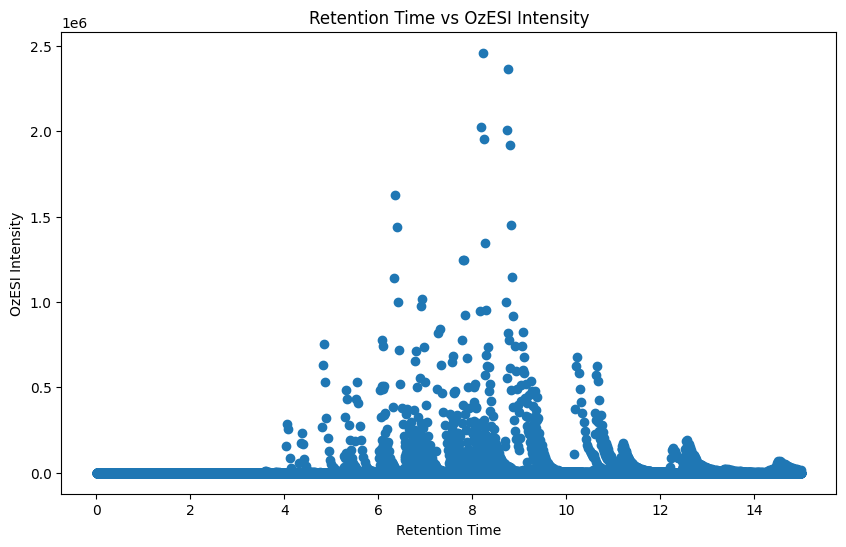

In [8]:
parser = OzESI.RawDataParser(mrm_csv_path, oze_esi_csv_path)


# Parse the data
parsed_data = parser.parse_data(retention_time_range, new_columns, group_columns, project_results_directory, file_name_to_save, mode)

# Save raw data
save_status = parser.save_raw_data(project_results_directory, file_name_to_save, mode)

# Plot the full spectrum
parser.plot_full_spectrum(raw_data_csv)

# Plot the full spectrum

In [9]:
# Print the parsed data
print(parsed_data)



RawDataParser complete, output saved to Projects/AMP/results/fame_mix/csv_data/FAME_RawDataParser_ON.csv


# PeakAnalysis Class
### find peaks, RT and peak area 
### input df from RawDataParser and output is df

In [10]:

# Create an instance of PeakAnalysis
peak_analysis = OzESI.PeakAnalysis(raw_data_csv, mode)

# Perform peak analysis
peaks_df = peak_analysis.find_lipid_peaks(use_match_group=True, height=50000, width=2, rel_height=0.5, project_results=Project_results, file_name_to_save=file_name_to_save, user_input=mode)


Sampling Interval: 0.0262166666666666
Sampling Interval: 0.026233333333333303
Group_Sample: -1 - Peak 0: Start Time = 7.526583333333334, End Time = 7.631516666666667, Width = 0.10493333333333332, FWHM = 0.08997482079019525
Sampling Interval: 0.026233333333333296
Group_Sample: -1 - Peak 0: Start Time = 6.634216666666667, End Time = 6.73915, Width = 0.10493333333333332, FWHM = 0.09153619244746856
Group_Sample: -1 - Peak 1: Start Time = 7.578600000000001, End Time = 7.6573, Width = 0.07869999999999955, FWHM = 0.0976283883750349
Sampling Interval: 0.0262166666666667
Group_Sample: -1 - Peak 0: Start Time = 6.633766666666667, End Time = 6.738700000000001, Width = 0.10493333333333332, FWHM = 0.0939969138572171
Group_Sample: -1 - Peak 1: Start Time = 7.57815, End Time = 7.683083333333333, Width = 0.10493333333333332, FWHM = 0.0996088517830315
Sampling Interval: 0.026216666666666704
Group_Sample: -1 - Peak 0: Start Time = 6.738250000000001, End Time = 6.843183333333334, Width = 0.10493333333333

In [11]:
peaks_df

############### WRITE A FUNCTION TO EASILY SCAN FOR SPECIFIC LIPIDS AN FIND THEIR MATCH GROUP OR GORUP SAMPLE
########## DOUBLE CHECK AREA CALCULATION

,Lipid,Retention_Time,OzESI_Intensity,Match_Group,Group_Sample,Sample_ID,Parent_Ion,Product_Ion,FAC,Biology,Genotype,Cage,Mouse,Peak_Height,FWHM,Peak_Width,Peak_Area
0,"22:6 (4Z,7Z,10Z,13Z,16Z,19Z)n-3,n-6,n-9,n-12,n...",7.579050,64931.144531,1,-1,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,269.1,183.0,"['22:6', '12:1', '13:1', '14:1', '15:1', '16:1...",NaN,NaN,NaN,NaN,64931.144531,0.089975,0.104933,6813.441433
1,"6:0 / 20:5 (5Z,8Z,11Z,14Z,17Z)n-3,n-6,n-9,n-12...",6.686683,64325.605469,2,-1,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,283.1,183.0,"['6:0', '20:5', '20:4', '12:1', '13:1', '14:1'...",NaN,NaN,NaN,NaN,64325.605469,0.091536,0.104933,6749.900201
2,"6:0 / 20:5 (5Z,8Z,11Z,14Z,17Z)n-3,n-6,n-9,n-12...",7.631067,91986.468750,2,-1,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,283.1,183.0,"['6:0', '20:5', '20:4', '12:1', '13:1', '14:1'...",NaN,NaN,NaN,NaN,91986.468750,0.097628,0.078700,7239.335091
3,"6:0 / 20:5 (5Z,8Z,11Z,14Z,17Z)n-3,n-6,n-9,n-12...",6.686233,70811.421875,3,-1,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,283.3,183.0,"['6:0', '20:5', '20:4', '12:1', '13:1', '14:1'...",NaN,NaN,NaN,NaN,70811.421875,0.093997,0.104933,7430.478535
4,"6:0 / 20:5 (5Z,8Z,11Z,14Z,17Z)n-3,n-6,n-9,n-12...",7.630617,105181.585938,3,-1,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,283.3,183.0,"['6:0', '20:5', '20:4', '12:1', '13:1', '14:1'...",NaN,NaN,NaN,NaN,105181.585938,0.099609,0.104933,11037.054418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,20:1,10.655467,625269.312500,43,-1,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,477.4,183.0,['20:1'],NaN,NaN,NaN,NaN,625269.312500,0.145964,0.157400,98417.389788
79,20:0 / 21:1n-2 / 22:1n-3,12.281450,147127.203125,44,-1,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,479.4,183.0,"['20:0', '21:1', '22:1']",NaN,NaN,NaN,NaN,147127.203125,0.226471,0.236100,34736.732658
80,22:6,7.584817,314451.750000,46,-1,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,495.4,183.0,['22:6'],NaN,NaN,NaN,NaN,314451.750000,0.092633,0.078700,24747.352725
81,22:2,11.204517,164623.828125,47,-1,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,503.4,183.0,['22:2'],NaN,NaN,NaN,NaN,164623.828125,0.162672,0.157383,25909.046816


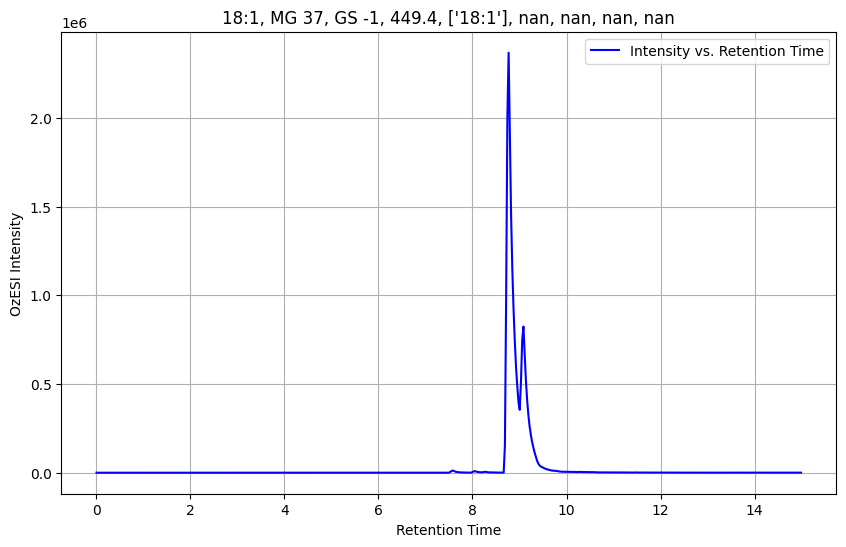

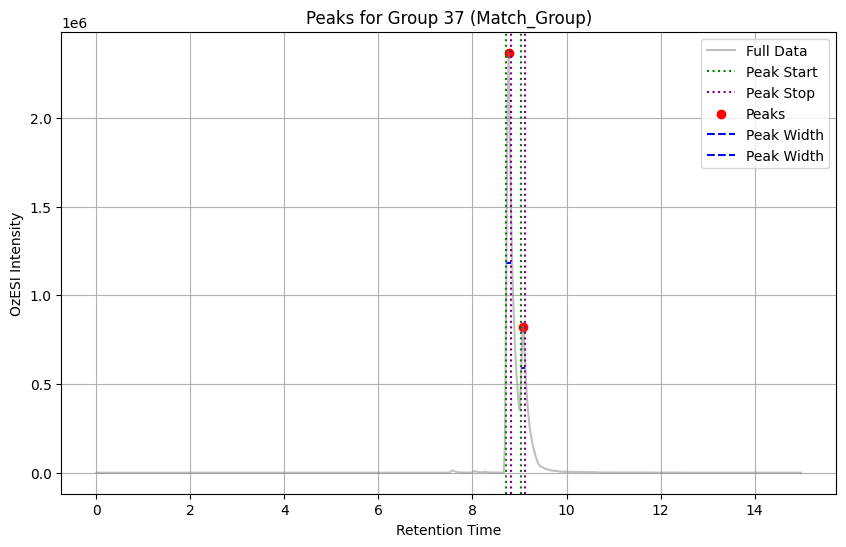

In [12]:

# Plot data and peaks for a specific group
peak_analysis.plot_data_and_peaks(raw_data_csv, peak_analysis_csv,group_type='Match_Group', group_value=37, height=50000, width=2, rel_height=0.5)

In [13]:
peaks_df

,Lipid,Retention_Time,OzESI_Intensity,Match_Group,Group_Sample,Sample_ID,Parent_Ion,Product_Ion,FAC,Biology,Genotype,Cage,Mouse,Peak_Height,FWHM,Peak_Width,Peak_Area
0,"22:6 (4Z,7Z,10Z,13Z,16Z,19Z)n-3,n-6,n-9,n-12,n...",7.579050,64931.144531,1,-1,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,269.1,183.0,"['22:6', '12:1', '13:1', '14:1', '15:1', '16:1...",NaN,NaN,NaN,NaN,64931.144531,0.089975,0.104933,6813.441433
1,"6:0 / 20:5 (5Z,8Z,11Z,14Z,17Z)n-3,n-6,n-9,n-12...",6.686683,64325.605469,2,-1,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,283.1,183.0,"['6:0', '20:5', '20:4', '12:1', '13:1', '14:1'...",NaN,NaN,NaN,NaN,64325.605469,0.091536,0.104933,6749.900201
2,"6:0 / 20:5 (5Z,8Z,11Z,14Z,17Z)n-3,n-6,n-9,n-12...",7.631067,91986.468750,2,-1,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,283.1,183.0,"['6:0', '20:5', '20:4', '12:1', '13:1', '14:1'...",NaN,NaN,NaN,NaN,91986.468750,0.097628,0.078700,7239.335091
3,"6:0 / 20:5 (5Z,8Z,11Z,14Z,17Z)n-3,n-6,n-9,n-12...",6.686233,70811.421875,3,-1,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,283.3,183.0,"['6:0', '20:5', '20:4', '12:1', '13:1', '14:1'...",NaN,NaN,NaN,NaN,70811.421875,0.093997,0.104933,7430.478535
4,"6:0 / 20:5 (5Z,8Z,11Z,14Z,17Z)n-3,n-6,n-9,n-12...",7.630617,105181.585938,3,-1,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,283.3,183.0,"['6:0', '20:5', '20:4', '12:1', '13:1', '14:1'...",NaN,NaN,NaN,NaN,105181.585938,0.099609,0.104933,11037.054418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,20:1,10.655467,625269.312500,43,-1,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,477.4,183.0,['20:1'],NaN,NaN,NaN,NaN,625269.312500,0.145964,0.157400,98417.389788
79,20:0 / 21:1n-2 / 22:1n-3,12.281450,147127.203125,44,-1,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,479.4,183.0,"['20:0', '21:1', '22:1']",NaN,NaN,NaN,NaN,147127.203125,0.226471,0.236100,34736.732658
80,22:6,7.584817,314451.750000,46,-1,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,495.4,183.0,['22:6'],NaN,NaN,NaN,NaN,314451.750000,0.092633,0.078700,24747.352725
81,22:2,11.204517,164623.828125,47,-1,11152023_FAMEmix_AMP_1000x_0.1uMd216-0_MRMs_O3...,503.4,183.0,['22:2'],NaN,NaN,NaN,NaN,164623.828125,0.162672,0.157383,25909.046816


# OZONE COMPARE

############################################

In [14]:

# Create an instance of OzoneCompare

# # Paths to the ON and OFF CSV files
# peak_analysis_csv_on = f"{file_name_to_save}_PeakAnalysis_ON.csv"
# peak_analysis_csv_off = f"{file_name_to_save}_PeakAnalysis_OFF.csv"





# # Path to OzoneCompare output file
# ozone_compare_csv = f"{file_name_to_save}_OzoneCompared.csv"

# Print the paths of each input being used
print(f"CSV data folder: {csv_data_folder}")
print(f"Peak Analysis ON file: {os.path.join(csv_data_folder, peak_analysis_csv_on)}")
print(f"Peak Analysis OFF file: {os.path.join(csv_data_folder, peak_analysis_csv_off)}")
print(f"Ozone Compare output file: {os.path.join(csv_data_folder, ozone_compare_csv)}")

# Create an instance of OzoneCompare
ozone_compare = OzoneCompare(csv_data_folder, peak_analysis_csv_on, peak_analysis_csv_off, ozone_compare_csv)

# Match the dataframes
matched_df = ozone_compare.match_dataframes()

# Filter the matched DataFrame if needed
filtered_df = ozone_compare.filter_contains_colon_zero(matched_df)

# Save the matched DataFrame to a CSV file
ozone_compare.save_matched_data(filtered_df)

# Print the path where the Ozone matched CSV file was saved
output_path = os.path.join(csv_data_folder, ozone_compare_csv)
print(f"Process completed. Matched data saved to {output_path}")



CSV data folder: ./Projects/AMP/results/fame_mix/csv_data/
Peak Analysis ON file: ./Projects/AMP/results/fame_mix/csv_data/FAME_PeakAnalysis_ON.csv
Peak Analysis OFF file: ./Projects/AMP/results/fame_mix/csv_data/FAME_PeakAnalysis_OFF.csv
Ozone Compare output file: ./Projects/AMP/results/fame_mix/csv_data/fame_mix_ON.csv_OzoneCompared.csv
Loaded ON data:                                                Lipid  Retention_Time  \
0  22:6 (4Z,7Z,10Z,13Z,16Z,19Z)n-3,n-6,n-9,n-12,n...        7.579050   
1  6:0 / 20:5 (5Z,8Z,11Z,14Z,17Z)n-3,n-6,n-9,n-12...        6.686683   
2  6:0 / 20:5 (5Z,8Z,11Z,14Z,17Z)n-3,n-6,n-9,n-12...        7.631067   
3  6:0 / 20:5 (5Z,8Z,11Z,14Z,17Z)n-3,n-6,n-9,n-12...        6.686233   
4  6:0 / 20:5 (5Z,8Z,11Z,14Z,17Z)n-3,n-6,n-9,n-12...        7.630617   

   OzESI_Intensity  Match_Group  Group_Sample  \
0     64931.144531            1            -1   
1     64325.605469            2            -1   
2     91986.468750            2            -1   
3     70811.42

## PLOTS 

Looking for CSV file at: ./Projects/AMP/results/fame_mix/csv_data/FAME_PeakAnalysis_ON.csv
Loaded DataFrame with 83 rows and 17 columns.
DataFrame columns: Index(['Lipid', 'Retention_Time', 'OzESI_Intensity', 'Match_Group',
       'Group_Sample', 'Sample_ID', 'Parent_Ion', 'Product_Ion', 'FAC',
       'Biology', 'Genotype', 'Cage', 'Mouse', 'Peak_Height', 'FWHM',
       'Peak_Width', 'Peak_Area'],
      dtype='object')
Directory already exists at Projects/AMP/results/fame_mix/plots/on/
Lipid: 10:0 / 18:2 (9Z,12Z)n-6,n-9 / 14:1 (9Z)n-5 / 18:3 (9Z,12Z,15Z))n-3.n-6,n-9 / 16:1 (9Z)n-7 / 18:1(9Z)n-9, Data Points: 8, Intensities: [286286.125, 116090.3671875, 110029.6640625, 289018.90625, 203691.1875, 305479.28125, 816327.25, 600889.0]
Lipid: 11:0 / 15:1 (10Z)n-5 / 17:1 (10Z)n-7, Data Points: 3, Intensities: [231466.78125, 189818.09375, 398123.9375]
Lipid: 12:0 / 20:2 (11Z,14Z)n-6,n-9 / 20:3 (11Z,14Z,17Z)n-3,n-6,n-9 / 20:1 (11Z)n-9 / 18:1n-7, Data Points: 4, Intensities: [756967.875, 182506.1

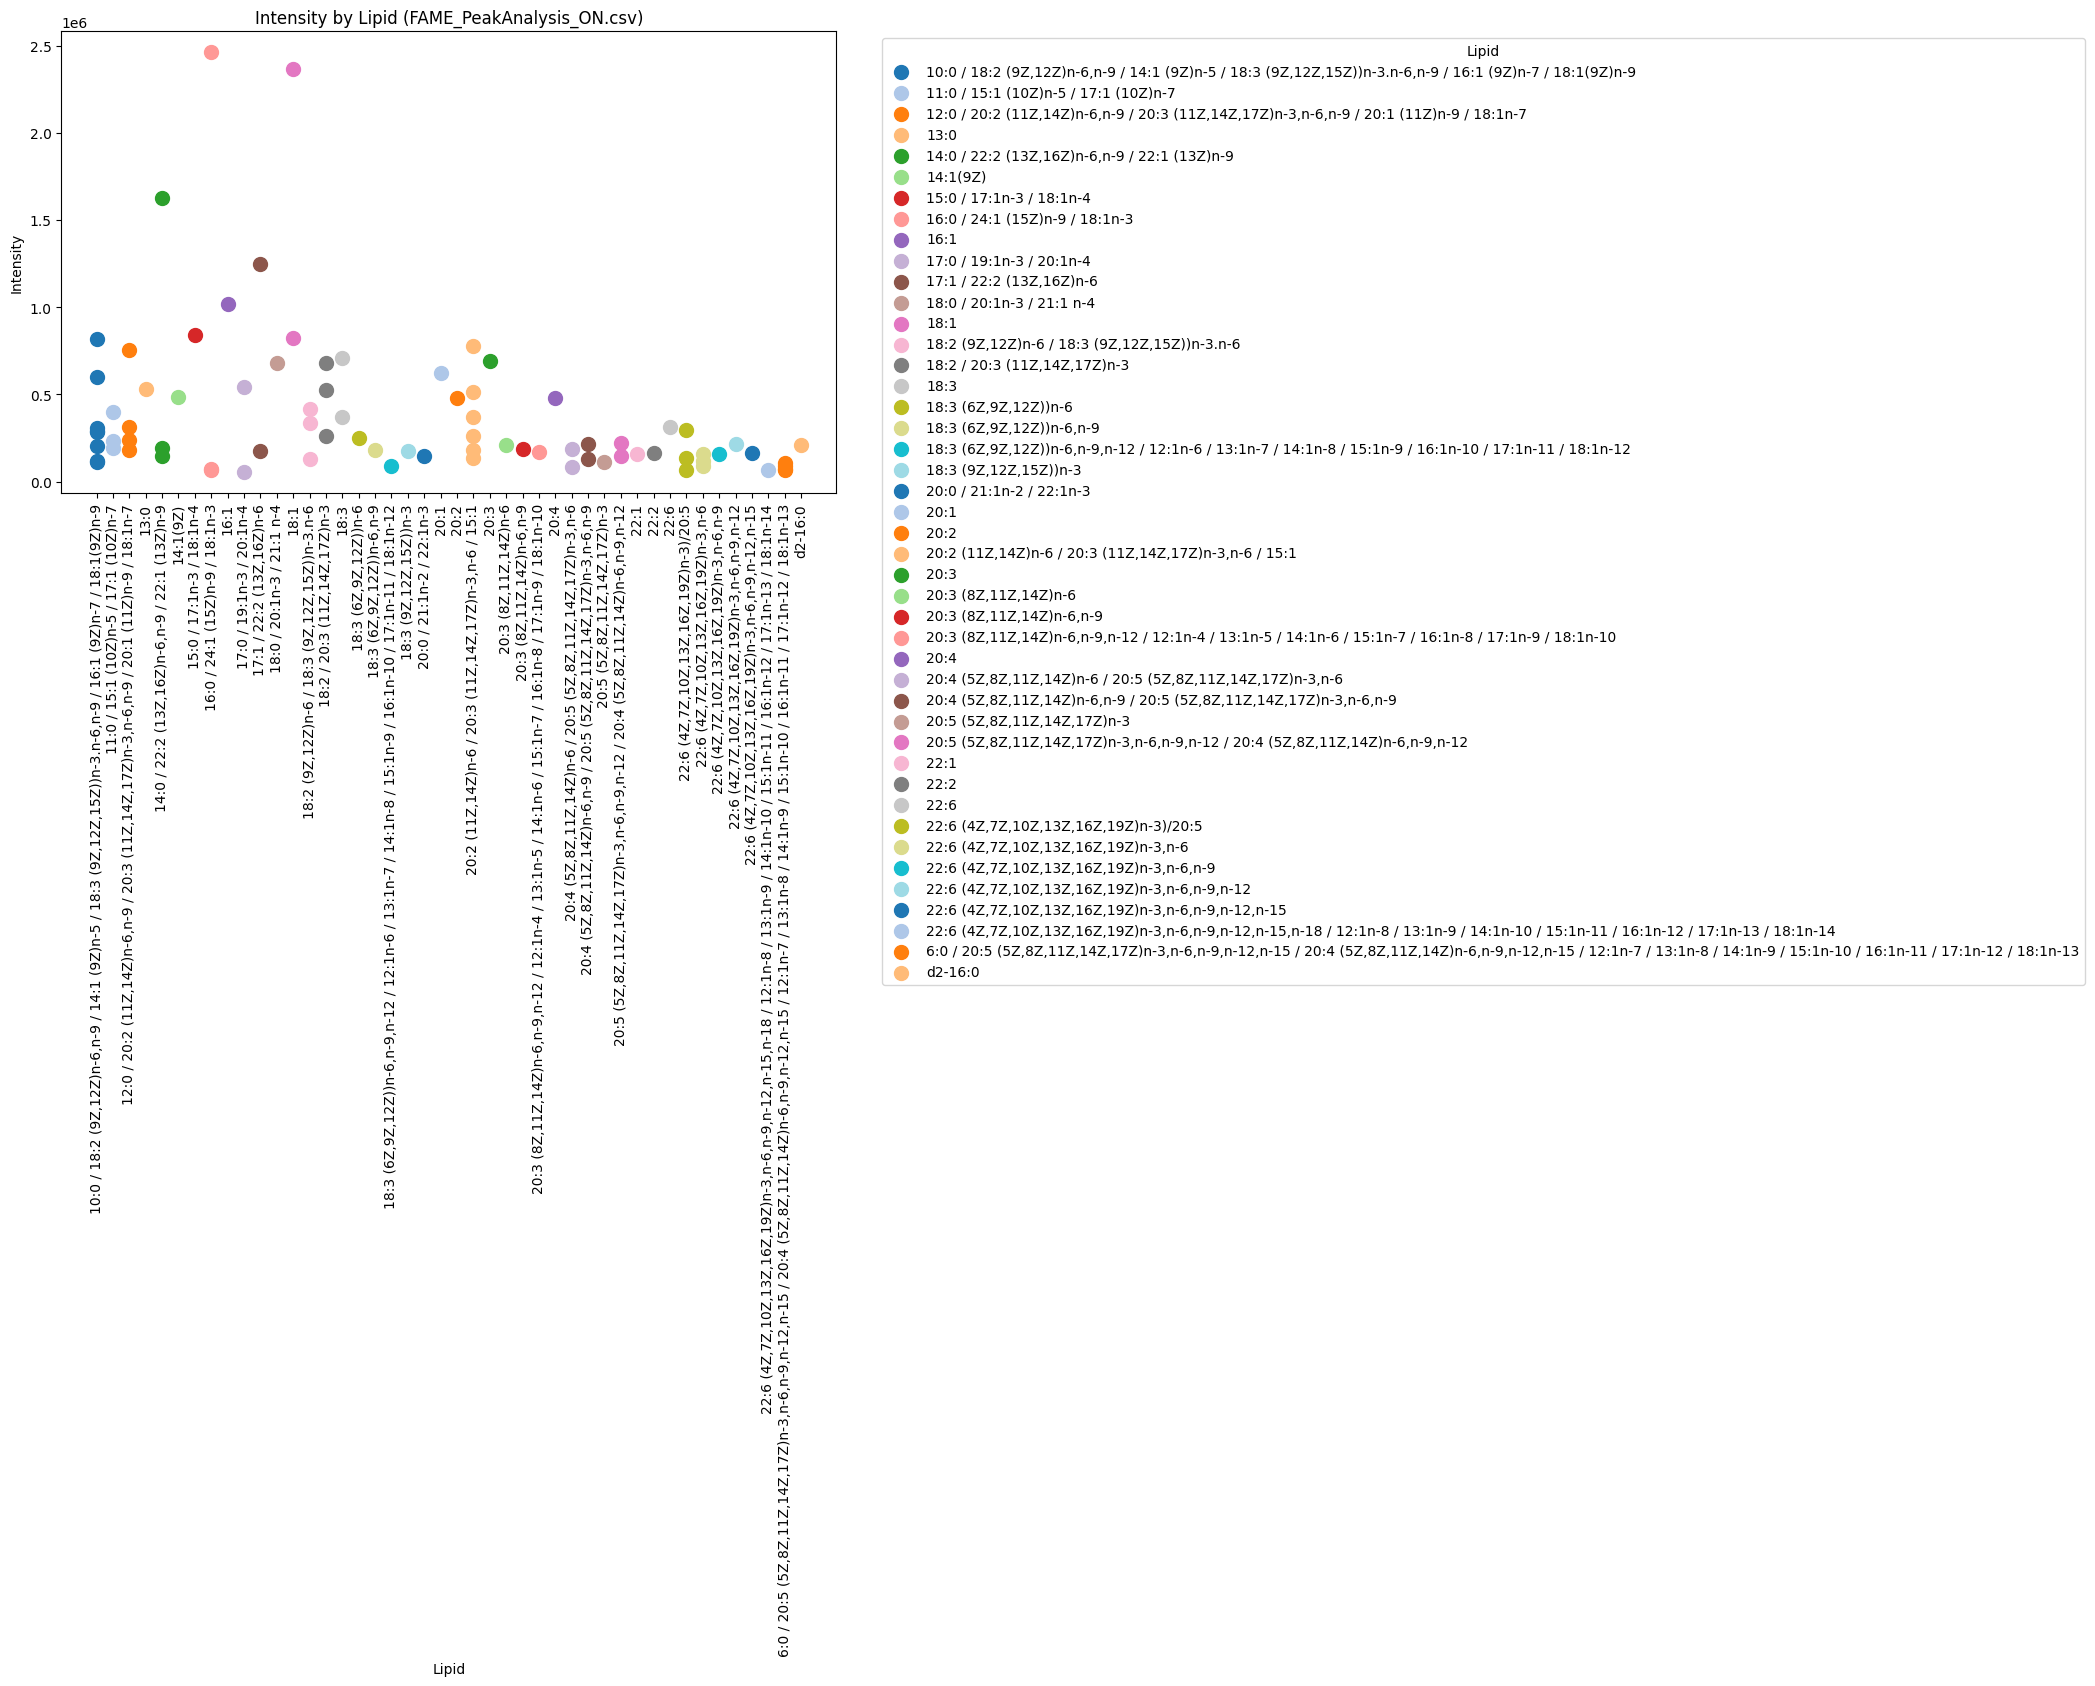

Looking for CSV file at: ./Projects/AMP/results/fame_mix/csv_data/FAME_PeakAnalysis_ON.csv
Loaded DataFrame with 83 rows and 17 columns.
DataFrame columns: Index(['Lipid', 'Retention_Time', 'OzESI_Intensity', 'Match_Group',
       'Group_Sample', 'Sample_ID', 'Parent_Ion', 'Product_Ion', 'FAC',
       'Biology', 'Genotype', 'Cage', 'Mouse', 'Peak_Height', 'FWHM',
       'Peak_Width', 'Peak_Area'],
      dtype='object')
Directory already exists at Projects/AMP/results/fame_mix/plots/on/
Grouped Data:                                                 Lipid  OzESI_Intensity
0   10:0 / 18:2 (9Z,12Z)n-6,n-9 / 14:1 (9Z)n-5 / 1...     8.163272e+05
1                11:0 / 15:1 (10Z)n-5 / 17:1 (10Z)n-7     3.981239e+05
2   12:0 / 20:2 (11Z,14Z)n-6,n-9 / 20:3 (11Z,14Z,1...     7.569679e+05
3                                                13:0     5.321299e+05
4        14:0 / 22:2 (13Z,16Z)n-6,n-9 / 22:1 (13Z)n-9     1.625926e+06
5                                            14:1(9Z)     4.851717e+0

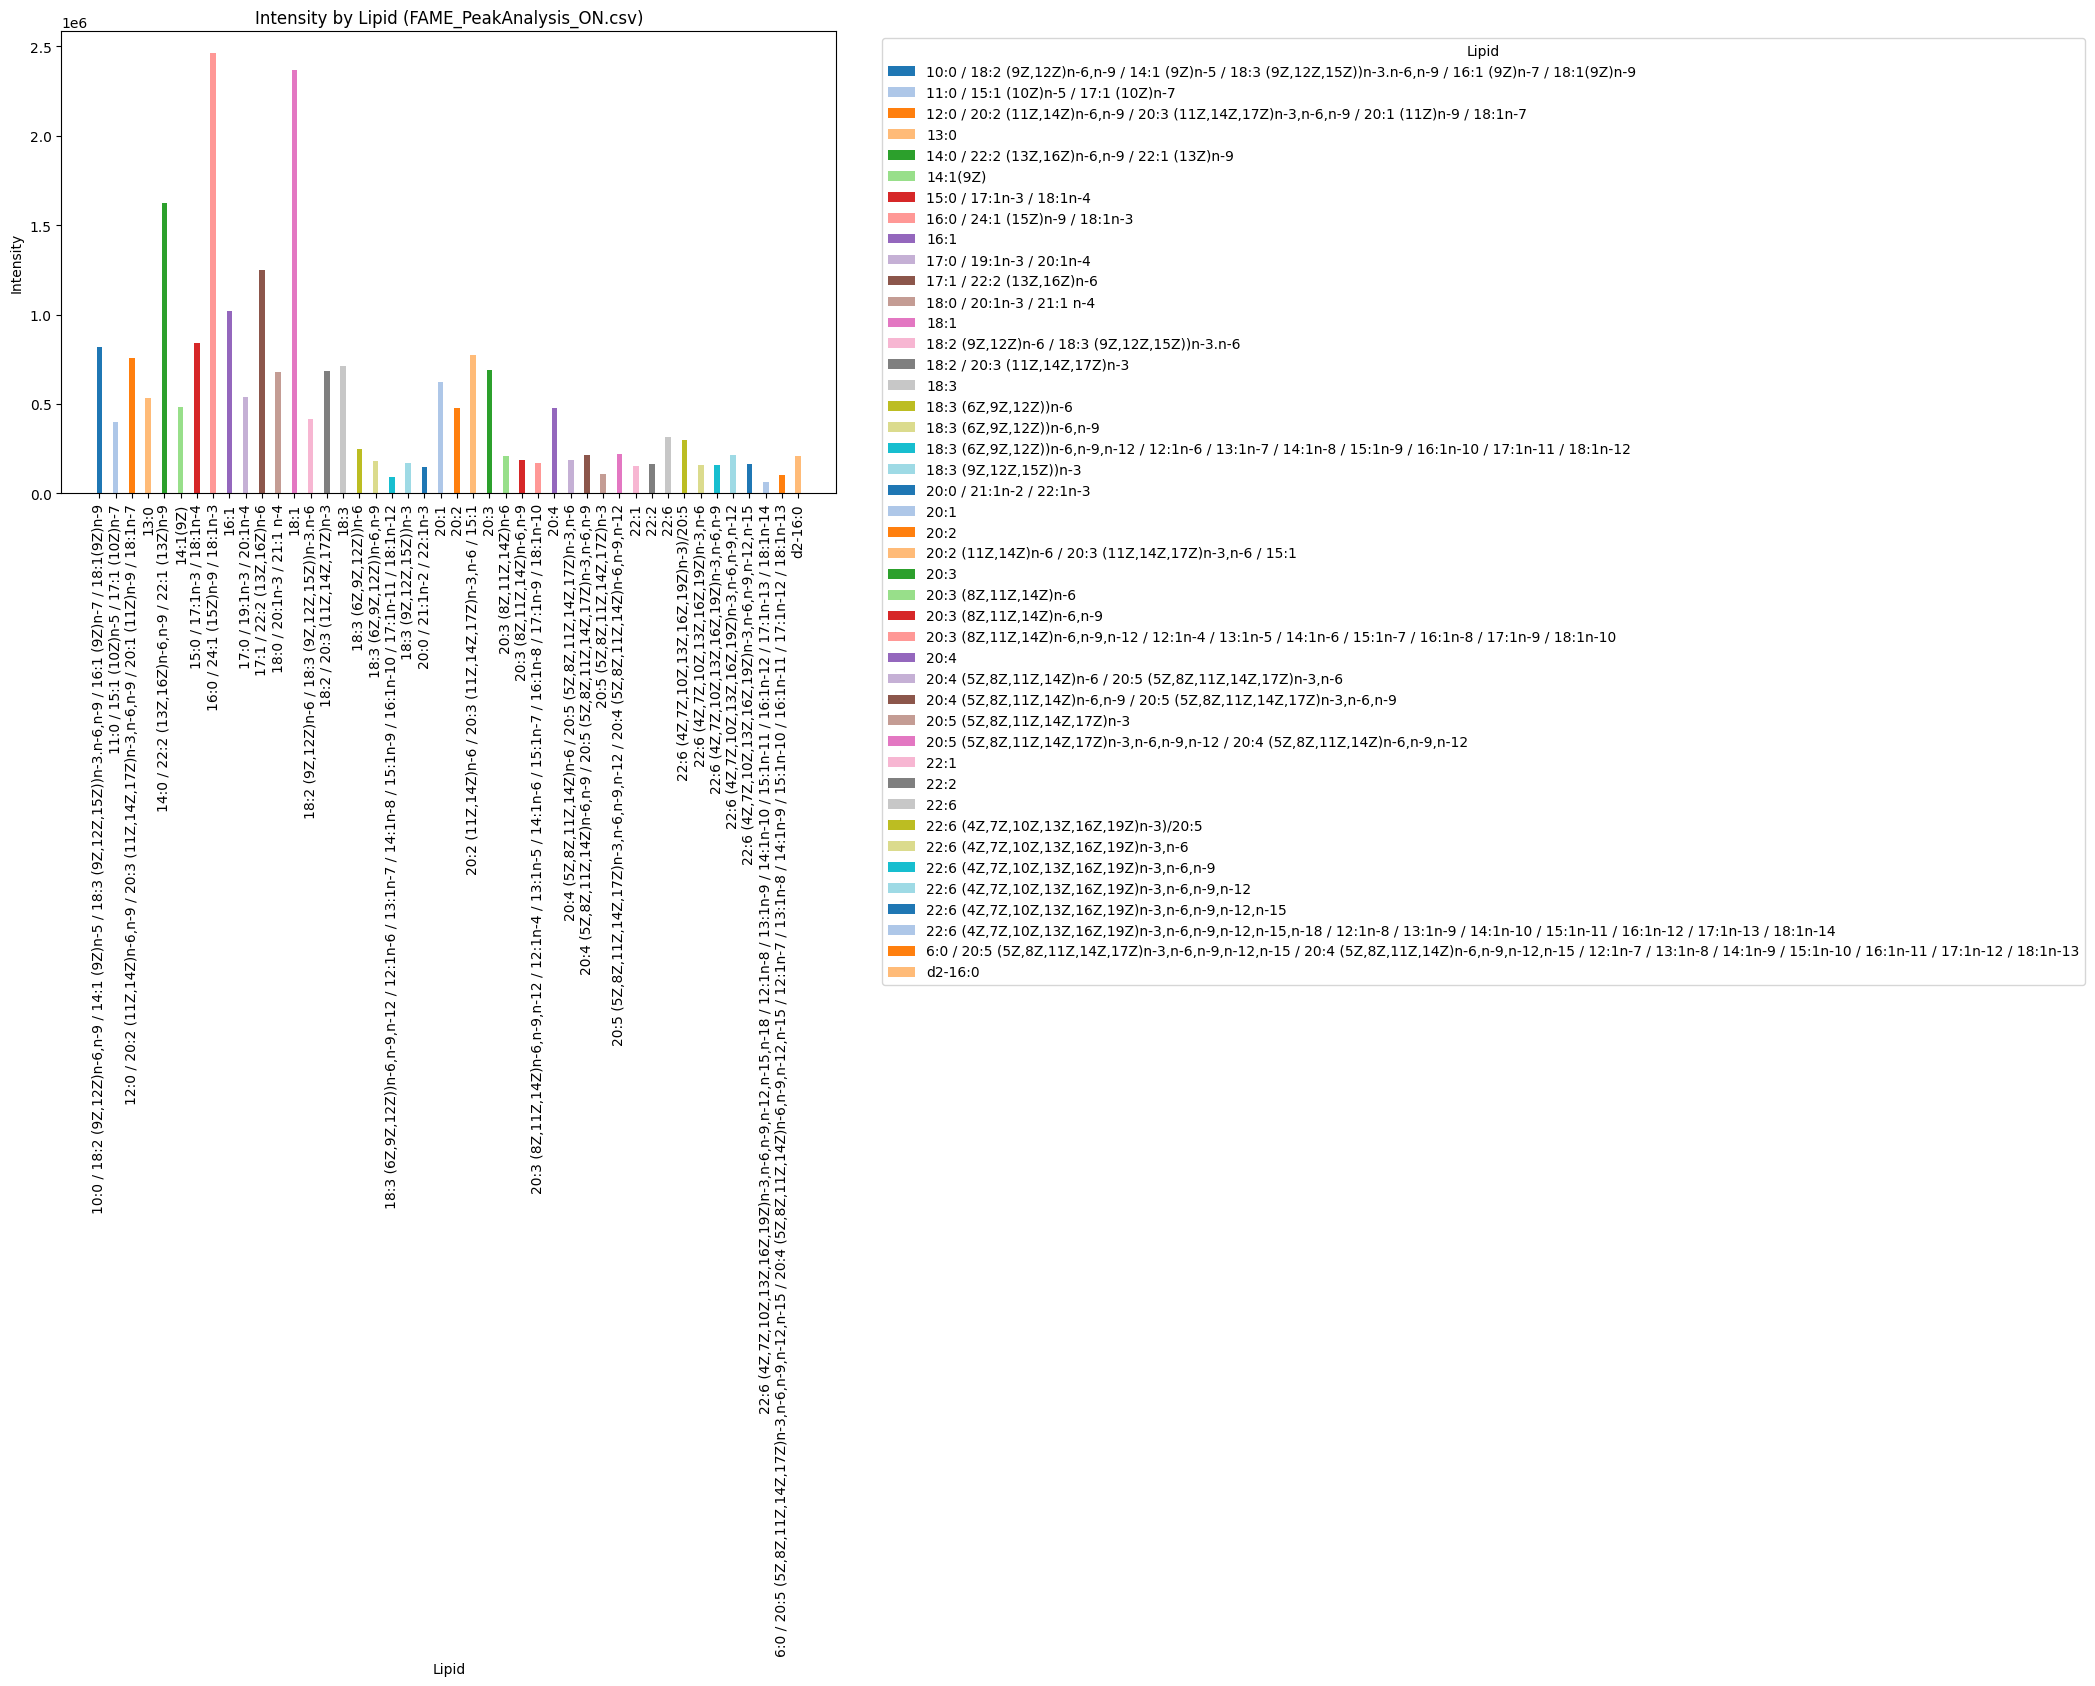

In [15]:


# Initialize the Plot class
plotter = Plot(csv_data_folder, peak_analysis_csv_on, peak_analysis_csv_off, ozone_compare_csv, plots_directory)

# Create a scatter plot with use_ozone_compare argument
plotter.scatter(use_ozone_compare=False, mode=mode)

# Create a bar plot with use_ozone_compare argument
plotter.plot_bar(use_ozone_compare=False, mode=mode)


# # Create bar plots by group sample with use_ozone_compare argument
# plotter.plot_bar_by_group_sample(use_ozone_compare=True, mode='ON', group_type='Match_Group')


In [16]:
# # Create a bar plot with use_ozone_compare argument
# plotter.plot_bar(use_ozone_compare=False, mode=mode)